In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
from scipy.special import j0, j1
from numpy import meshgrid
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['text.usetex'] = True

## We will use the wall-to-bed heat transfer model provided by Muroyama and others [1]


We know that 

Average Molar Mass of the liquid Mixture: $78.09359 [g/mol]$

Average Molar Mass of the gas Mixture: $2.02493 [g/mol]$

The mass flow rate of gas: $10178.8 [kg / hr]$

The mass flow rate of liquid: $412805.3 [kg / hr]$

CSA of column = 0.2 [m]

Heat capcity of liquid mixture: $2.93 * 10^4 [J / kmol / K]$

Heat capacity of gas: $1.92 * 10^5 [J / kmol / K]$

In [2]:
# Mass flow rate of gas per unit volume
G_g = 10178.8 / 0.2 / 60 / 60   # [kg m^-2 s^-1]

# Mass flow rate of liquid per unit volume
G_l = 412805.3 / 0.2 / 60 / 60  # [kg m^-2 s^-1]

# Heat capacity of liquid
C_pl = 2.93e4 / 1000 / (78 / 1000)  # [J kg^-1 K^-1]

# Heat capacity of gas
C_pg_star = 1.92e5 / 1000 / (2 / 1000)  # [J kg^-1 K^-1]

### Estimating the Heat Capacity of the catalyst particle

Since we know the catalyst composition is as follows:

[𝐿𝑖^+ }=60.93 [𝑤𝑡%]; [𝐴𝑙^(3+) ]=32.93 [𝑤𝑡%]; [𝑅𝑢]=1.2 [𝑤𝑡%]; [𝑍𝑛^(2+) ]=4.94 [𝑤𝑡%]



In [3]:
# Weight percentages and specific heat capacities of components

wt_percentages = {'Li': 60.93, 'Al': 32.93, 'Ru': 1.2, 'Zn': 4.94}

specific_heat_capacities = {'Li': 3.58, 'Al': 0.897, 'Ru': 0.238, 'Zn': 0.387} # J/g°C

# Calculate the estimated heat capacity of the catalyst
cp_catalyst = sum(wt_percentages[element] / 100 * specific_heat_capacities[element] for element in wt_percentages)

# Conversion factor from J/g°C to J/kg·K
conversion_factor = 1000

# Convert the heat capacity to J/kg·K
cp_catalyst_kg_K = cp_catalyst * conversion_factor

print(f"The heat capacity of the catalyst particle: {cp_catalyst_kg_K} [J / kg / K]")

The heat capacity of the catalyst particle: 2498.6499 [J / kg / K]


### Effective Axial Thermal Conductivity

$$
k_{ez} = (\rho_l C_{pl} \varepsilon_l + \rho_s C_{ps} \varepsilon_s) E_{zl}
$$

In [4]:
def cal_E_l(U_l=5, U_g=30,d_p=3.5e-3, D_c=0.2):
    """ Axial dispersion coefficient (kim and kim) [2]"""
    numer = d_p * U_l
    denom = 20.19 * (d_p/D_c)**(1.66) * (U_l / (U_l + U_g))**(1.03)
    
    if numer == 0: 
        return 0
    
    return numer / denom

In [5]:
def cal_holdups(U_g=30, U_l=5, d_p=3.5e-3, D_c=0.2, rho_p=1.72e5,rho_l=730,mu_l=1.7e-4):
    """
    Calculate gas, solids, and liquid holdups ensuring they sum to 1. (Begovich and Watson, 1978) [4]
    
    Parameters:
    U_g: Gas velocity
    U_l: Liquid velocity
    d_p: Particle diameter
    D_c: Column diameter
    rho_p: Particle density
    rho_l: Liquid density
    mu_l: Liquid viscosity

    Returns:
    A tuple of (eps_g, eps_s, eps_l) representing gas, solids, and liquid holdups.
    """
    # Check if either U_g or U_l is zero
    if U_g == 0 or U_l == 0:
        # Handle the case where gas or liquid velocity is zero
        # You can define what eps_g, eps_s, and eps_l should be in this case
        # For example, assuming all gas or all liquid
        return (1.0, 0.0, 0.0) if U_g == 0 else (0.0, 0.0, 1.0)

    # Calculate gas and solids holdups based on the given formulas
    eps_g = 0.048 * U_g**(0.72) * d_p**(0.168) * D_c**(-0.125)
    term1 = 0.371 * (U_l**(0.271)) * (U_g**(0.041)) * ((rho_p - rho_l)**(-0.316)) * d_p**(-0.268) * mu_l**(0.055) * D_c**(-0.033)
    eps_s = 1 - term1

    # Ensure eps_g and eps_s are not zero; adjust as necessary
    eps_g = max(eps_g, 0.001)
    eps_s = max(eps_s, 0.001)

    # Calculate liquid holdup, ensuring the sum of eps_g, eps_s, and eps_l is 1
    eps_l = 1 - eps_g - eps_s

    # Ensure eps_l is not zero; adjust as necessary
    eps_l = max(eps_l, 0.001)

    # If adjustment made eps_l negative, distribute the excess to eps_g and eps_s proportionally
    if eps_l < 0:
        excess = abs(eps_l)
        total_eps = eps_g + eps_s
        eps_g -= (eps_g / total_eps) * excess
        eps_s -= (eps_s / total_eps) * excess
        eps_l = 0.001

    return eps_g, eps_s, eps_l

In [6]:
def calculate_kez():
    """Calculate the effective axial thermal conductivity [W m^-1 K^-1] """
    
    Ezl = cal_E_l()
    
    rho_s = 1.72e5
    
    rho_l = 730
    
    Cpl = 2.93e4 / 1000 / (78 / 1000)
    
    Cps = 2498.6499
    
    eps_l, eps_s = cal_holdups()[2], cal_holdups()[1]
    
    return (rho_l * Cpl * eps_l + rho_s * Cps * eps_s) * Ezl

## Effective radial thermal conductivity

We assume that the effecitve radial thermal conductivity would be the same as the effective axial conductivity

In [7]:
k_ez = calculate_kez()
k_er = calculate_kez()

print(f"The effective axial thermal conductivity: {k_ez:.1f} [W / m / K]")
print(f"The effective radial thermal conductivity: {k_ez:.1f} [W / m / K]")

The effective axial thermal conductivity: 2181650627.8 [W / m / K]
The effective radial thermal conductivity: 2181650627.8 [W / m / K]


## Apparently wall Heat Transfer Coefficient

Since the formation of clusters from individual solid particles is a feature of three-phase fluidized beds [1]. 

Thus, we are using a cluster-based approach instead of a particle-based approach to describe heat transfer behaviour which studies unsteady state heat transfer between particle pockets as they are in contact with the hot surface [5]. 

In this case an ANN approach to calculate the apparent wall heat transfer coefficent


In [8]:
def sigmoid(x):
    """Sigmoid activation function."""
    # Clip x to avoid overflow in exp
    # 709 is chosen because np.exp(709) is close to the max float value
    x_clipped = np.clip(x, -709, 709) 
    return 1 / (1 + np.exp(-x_clipped))

def linear(x):
    """Linear activation function."""
    return x

class SimpleNN:
    def __init__(self, weights_hidden, biases_hidden, weights_output, bias_output):
        """Initialize the neural network with weights and biases."""
        self.weights_hidden = weights_hidden
        self.biases_hidden = biases_hidden
        self.weights_output = weights_output
        self.bias_output = bias_output

    def forward_pass(self, x):
        """Perform a forward pass."""
        # Hidden layer
        z_hidden = np.dot(x, self.weights_hidden) + self.biases_hidden
        a_hidden = sigmoid(z_hidden)
        
        
        # Output layer
        z_output = np.dot(a_hidden, self.weights_output) + self.bias_output
        output = linear(z_output)
        
        return output

weights_hidden = np.array([
    [-1.493, 0.744, 0.027, -0.383],
    [-9.428, 3.782, 6.941, -1.303],
    [-0.493, -0.375, -3.549, -0.584],
    [0.403, -0.102, -25.824, 32.324]
])

biases_hidden = np.array([0.047, 0.614, -4.519, 14.174])
weights_output = np.array([[-3.488], [2.653], [12.414], [2.238]])
bias_output = np.array([9.367])

# Initialize the neural network with the provided weights and biases
nn = SimpleNN(weights_hidden, biases_hidden, weights_output, bias_output)

In [9]:
# Input
input_size = 5  

# x = (d_p [m], \rho_p [kg / m^3], D_t [m], U_g [m/s])
# d_p is the particle diameter [m]
# \rho_p is the particle density [kg / m^3]
# D_t is the hydraulic diameter of the bed [m] which is the diameter of the reactor tube [m]
# U_g is the liquid velocity [m/s]

x = np.array([3.5e-5, 1.72e5, 0.2, 30])

# Perform a forward pass
output = nn.forward_pass(x)
h_w = output[0]
print(f"Apparent wall heat transfer coefficient:  {h_w} [W / m^2 / s]")

Apparent wall heat transfer coefficient:  24.434 [W / m^2 / s]


In [10]:
# Inner column radius
R = 0.2 / 2 # 0.1 [m]

### We will assume the length of the heated wall to be the same as the expanded bed height such that it is 3 [m]

In [11]:
L = 3.0  # [m]

### We assume the wall temperature is at ambient temperature such that $T_w = 25 [deg C] = 298 [K]$

In [12]:
T_w = 298 # [K]

### The initial temperature of the reactor content, $T_0 = 150 [deg C]  = 423 [K]$

In [13]:
T_0 = 423 # [K]

## The derived parameters

$
\mathscr{S} = \dfrac{h_w}{k_{er}}
$

$
\kappa = \dfrac{k_{er}}{G_l C_{pl} + G_g * C_{pg}^*}
$

$
\delta' = \dfrac{k_{ez}}{k_{er}}
$

In [14]:
# Derived parameters
S = h_w / k_er
kappa = k_er / (G_l * C_pl + G_g * C_pg_star)
delta_prime = k_ez / k_er

### Solving the transcendental equation

$
\mathscr{S} J_0 (R\zeta_i) = \zeta_i J_1(R \zeta_i)
$

In [15]:
# Function to find roots of the transcendental equation
def transcendental_eq(zeta, R, S):
    return S * j0(R * zeta) - zeta * j1(R * zeta)

# Initial guess for zeta
zeta_guess = 1

# Solve for zeta
root = fsolve(transcendental_eq, zeta_guess, args=(R, S))
zeta_i = root[0]
print("Root:", zeta_i)

Root: 0.0004732816657593766


In [17]:
# Creating a grid for the r and z dimensions
r = np.linspace(0, R, 50)
z = np.linspace(0, L, 50)
R_mesh, Z_mesh = meshgrid(r, z)


# Compute the temperature profile
Ai = np.sqrt(1 + 4 * kappa**2 * zeta_i**2 * delta_prime)


F = ((1 + Ai) * np.exp(((1 - Ai) * Z_mesh) / (2 * kappa * delta_prime)) - 
     (1 - Ai) * np.exp((((1 - Ai) * Z_mesh) - 2 * Ai * L) / (2 * kappa * delta_prime))) / \
    ((1 + Ai)**2 - (1 - Ai)**2 * np.exp(-Ai * L / (kappa * delta_prime)))


# Correctly calculate the term with proper 2D shape and handle divide-by-zero
denominator = (S**2 + zeta_i**2) * j0(R * zeta_i)  # This remains constant for a given zeta_i
series_term = np.where(denominator != 0, (S * j0(R_mesh * zeta_i)) / denominator, 0) * F

# Calculate T ensuring it maintains the 2D shape for plotting
T = T_w - (T_w - T_0) * (4 / R) * series_term

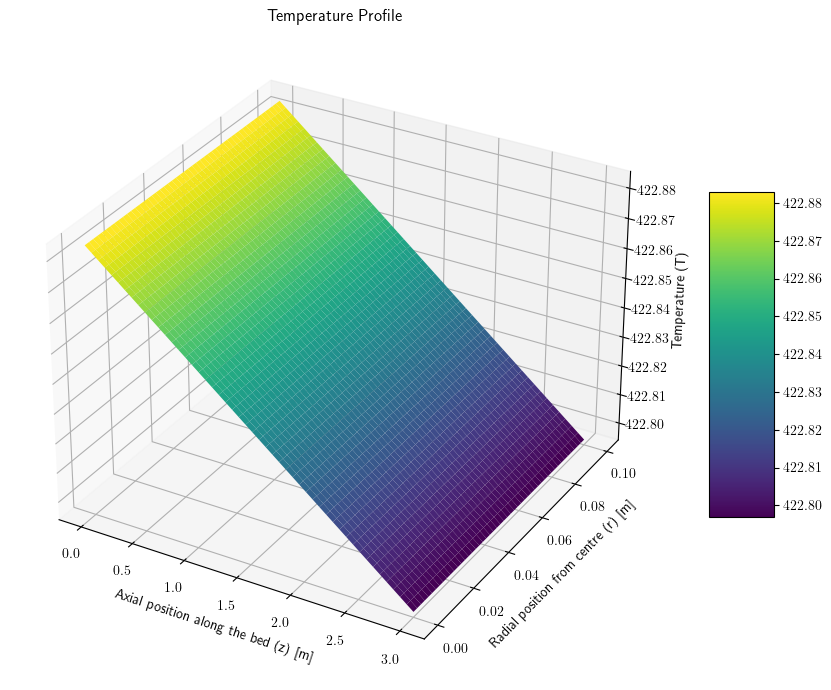

In [25]:
fig = plt.figure(figsize=(10, 7)) 

ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Z_mesh, R_mesh, T, cmap='viridis')

ax.set_xlabel('Axial position along the bed (z) [m]')
ax.set_ylabel('Radial position from centre (r) [m]')
ax.set_zlabel('Temperature (T)')

ax.set_title('Temperature Profile')

fig.colorbar(surf, shrink=0.5, aspect=5)  

plt.tight_layout()

plt.savefig("./graphs/Temperature_profile")
plt.show()


# References

[1]: K. Muroyama, M. Fukuma, and A. Yasunishi, “Wall-to-bed heat transfer in liquid-solid and gas-liquid-solid fluidized beds part II: Gas-liquid-solid fluidized beds,” The Canadian Journal of Chemical Engineering, vol. 64, no. 3, pp. 409–418, Jun. 1986, doi: https://doi.org/10.1002/cjce.5450640308.

[2]: Sang Done Kim and C. H. Kim, “Axial dispersion characteristics of three phase fluidized beds.,” vol. 16, no. 3, pp. 172–178, Jan. 1983, doi: https://doi.org/10.1252/jcej.16.172.

[3]: J. M. Begovich and J. S. Watson, “Hydrodynamic characteristics of three-phase fluidized beds,” www.osti.gov, Jan. 01, 1978. https://www.osti.gov/biblio/7208327 (accessed Feb. 17, 2024).

[4]: F. S. Mjalli and A. Al-Mfargi, “Artificial Neural Approach for Modeling the Heat and Mass Transfer Characteristics in Three-Phase Fluidized Beds,” Industrial & Engineering Chemistry Research, vol. 47, no. 13, pp. 4542–4552, May 2008, doi: https://doi.org/10.1021/ie0715714.

[5]: H. S. Mickley and D. F. Fairbanks, “Mechanism of heat transfer to fluidized beds,” vol. 1, no. 3, pp. 374–384, Sep. 1955, doi: https://doi.org/10.1002/aic.690010317.
